In [1]:
from scipy.signal import fftconvolve
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
test_set = "/scratch/datasets/astro_deconv_2019/test/"
test_start = 9400
test_end = 9700

In [3]:
#neural_output = "/scratch/vacuum-cleaner/test/astro_deconv_2019_l1gan/fits/"  #2.207
#neural_output = "/scratch/vacuum-cleaner/test/astro_deconv_2019_res_gan/fits/" # 2.29
#neural_output = "/scratch/vacuum-cleaner/test/astro_deconv_2019_res_gan_noscale_30Kiter/fits/" # 2.23
#neural_output = "/scratch/vacuum-cleaner/test/astro_deconv_2019_res_gan_noscale_lesslayers/fits/"
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_half_dataset/60000/fits/"  # 1.295
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_half_dataset/30000/fits/"  # 1.15
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale/60000/fits/"  # 2.545
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale/30000/fits/"  # 3.6
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_quarter_dataset/30000/fits/" # 4.25
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_quarter_dataset/60000/fits/" #  1.28
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_verify/60000/fits/"  # 1.09
#neural_output = "/scratch/vacuum-cleaner/eval/astro_deconv_2019_res_gan_noscale_nopsf/60000/fits/" # 1.14
#neural_output = "/scratch/vacuum-cleaner/eval_train/astro_deconv_2019_res_gan_noscale/60000/fits/"  # 2.45
neural_output = "/scratch/vacuum-cleaner/final_eval/gan/test/100000/fits/"  # 2.43

In [4]:
def render(a, imgdata, title):
    i = a.pcolor(imgdata, cmap='cubehelix')
    f.colorbar(i, ax=a)
    a.set_title(title)
    
def open_fits(x):
    return fits.open(x)[0].data.squeeze()

def convolve(convoled, convolver):
    p = convolver.shape[0]
    r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
    return fftconvolve(convoled, convolver, mode="full")[r,r]

In [5]:
l1_neural = []
indexes = []
l1_wsclean = []

for number in range(test_start, test_end):
    indexes.append(number)
    target_path = "{}{}-skymodel.fits".format(test_set, number)
    neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
    wsclean_model_path = "{}{}-wsclean-model.fits".format(test_set, number)
    clean_beam_path = "{}{}-clean-beam.fits".format(test_set, number)
    
    clean_beam = open_fits(clean_beam_path)
    target = open_fits(target_path)
    wsclean_model = open_fits(wsclean_model_path)
    neural_model = open_fits(neural_model_path )
    
    target_convolved = convolve(target, clean_beam)
    neural_convolved = convolve(neural_model, clean_beam)
    wsclean_convoled = convolve(wsclean_model, clean_beam)
    
    l1_neural.append(np.sum(np.abs( neural_model - target)))
    l1_wsclean.append(np.sum(np.abs( wsclean_model - target)))


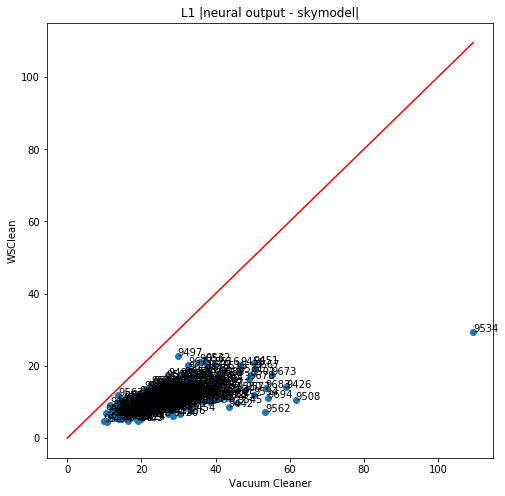

In [6]:
m = max(l1_wsclean + l1_neural)
f, (a1) = plt.subplots(1, 1, figsize=(8,8))
a1.plot(l1_neural, l1_wsclean, 'o')
a1.plot([0, m], [0, m], 'r-')
a1.set_xlabel('Vacuum Cleaner')
a1.set_ylabel('WSClean')
_ = a1.set_title('L1 |neural output - skymodel|')

for i, index in enumerate(indexes):
    if number in [9473]:
        continue
    a1.annotate(index, (l1_neural[i], l1_wsclean[i]))

In [7]:
sum(l1_neural), np.average(l1_neural), np.mean(l1_neural)

(8148.038291931152, 27.160128, 27.160128)

In [8]:
l1_scaling = 1/ np.average(l1_wsclean)

In [9]:
np.average(l1_wsclean) * l1_scaling   # should be 1.0-

1.0

In [10]:
# this is our weighted scoring function, higher is worse, 1.0 is wsclean
np.average(l1_neural) * l1_scaling 

2.437170466545605

In [11]:
number = 9534 # start + 2
target_path = "{}{}-skymodel.fits".format(test_set, number)
psf_path = "{}{}-psf.fits".format(test_set, number)
neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
wsclean_model_path = "{}{}-wsclean-model.fits".format(test_set, number)
neural_residual_path = "{}{}-residuals.fits".format(neural_output, number)
wsclean_residual_path = "{}{}-wsclean-residual.fits".format(test_set, number)
dirty_path = "{}{}-dirty.fits".format(test_set, number)

target = open_fits(target_path)
dirty = open_fits(dirty_path)
psf = open_fits(psf_path)
clean_beam = open_fits(clean_beam_path)


residuals_target = np.abs(dirty - convolve(target, psf))
residual_neural = np.abs(dirty - convolve(neural_model, psf))
residual_wsclean = np.abs(dirty - convolve(wsclean_model, psf))

    
neural_model = open_fits(neural_model_path)
wsclean_model = open_fits(wsclean_model_path)
target_convoled = convolve(target, clean_beam)
neural_convolved = convolve(neural_model, clean_beam)
wsclean_convolved = convolve(wsclean_model, clean_beam)

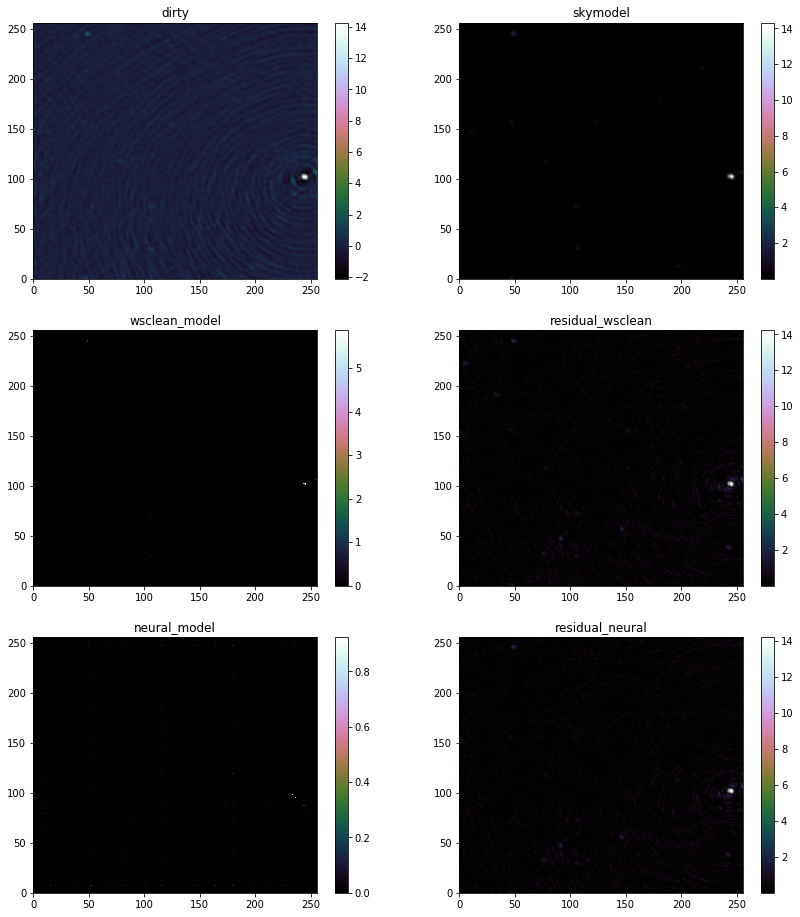

In [12]:
f, ((a1, a2), (a3, a4), (a5, a6)) = plt.subplots(3, 2, figsize=(14,16))
render(a1, dirty, 'dirty')
render(a2, target_convoled, 'skymodel')
render(a3, wsclean_model, 'wsclean_model')
render(a4, residual_wsclean, 'residual_wsclean')
render(a5, neural_model, 'neural_model')
render(a6, residual_neural, 'residual_neural')